## Finding Your Way In The City

In this notebook you'll combine the work of previous exercises to calculate a minimal series of waypoints in order to get from a start location to a goal location.

You'll reuse and modify your algorithms from:

- A*
- Configuration Space
- Collinearity and/or Bresenham

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from grid import create_grid
from planning import a_star

%matplotlib inline

from bresenham import bresenham

In [2]:
plt.rcParams['figure.figsize'] = 12, 12

You'll notice we've imported `create_grid`, and `a_star`. These are functions you've implemented in previous exercises, and here you'll use them to create a map and find a path from a starting position to a goal position.

To read the function signature and documentation execute `?` followed by the function name in a cell. In the example below we'll check the documentation for `create_grid`.

In [3]:
?bresenham

If you would like to alter these implementations, you can modify [grid.py](/edit/grid.py) and [planning.py](/edit/planning.py) in the current directory.

In [4]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ..., 
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [5]:
# Static drone altitude (meters)
drone_altitude = 5

# Minimum distance stay away from obstacle (meters)
safe_distance = 3

In [6]:
# TODO: Use `create_grid` to create a grid configuration space of
# the obstacle data.
grid = create_grid(data, drone_altitude, safe_distance)

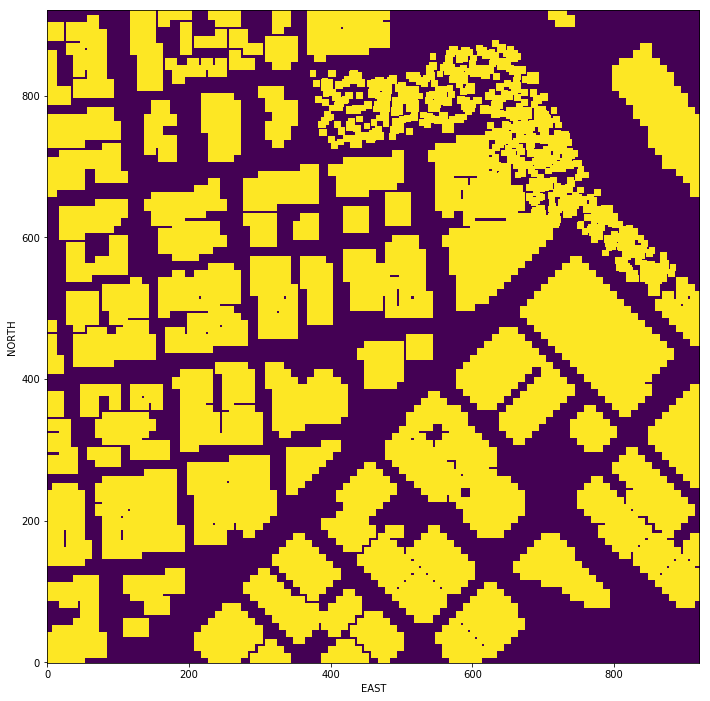

In [7]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower') 

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Next you'll compute the path from a start location to a goal location using A*.

Start and goal coordinates in *(north, east)*.

In [8]:
start_ne = (25,  100)
goal_ne = (750., 370.)

Write a heuristic function.

In [9]:
def heuristic_func(position, goal_position):
    # Use euclidean distance as the heuristic
    h = np.math.sqrt((goal_position[0] - position[0])**2 +
                     (goal_position[1] - position[1])**2)
    return h

Compute the lowest cost path with `a_star`. 

In [10]:
# TODO: use `a_star` to compute the lowest cost path
path, cost = a_star(grid, heuristic_func, start_ne, goal_ne)
print(path, cost)

Found a path.
[(25, 100), (26, 101), (27, 102), (28, 103), (29, 104), (30, 105), (31, 106), (32, 107), (33, 108), (34, 109), (35, 110), (36, 111), (36, 112), (36, 113), (36, 114), (36, 115), (36, 116), (36, 117), (36, 118), (36, 119), (36, 120), (36, 121), (36, 122), (36, 123), (36, 124), (36, 125), (36, 126), (36, 127), (36, 128), (36, 129), (36, 130), (36, 131), (36, 132), (36, 133), (36, 134), (36, 135), (36, 136), (36, 137), (36, 138), (36, 139), (36, 140), (36, 141), (36, 142), (36, 143), (37, 144), (38, 145), (39, 146), (40, 147), (41, 148), (42, 149), (43, 150), (44, 151), (45, 152), (46, 153), (47, 154), (48, 155), (49, 156), (50, 157), (51, 158), (52, 159), (53, 160), (54, 161), (55, 162), (56, 163), (57, 164), (58, 165), (59, 166), (60, 167), (61, 168), (62, 169), (63, 170), (64, 171), (65, 172), (66, 173), (67, 174), (68, 175), (69, 176), (70, 177), (71, 178), (72, 179), (73, 180), (74, 181), (75, 182), (76, 183), (77, 184), (78, 185), (79, 186), (80, 187), (81, 188), (82, 1

Let's plot the path!

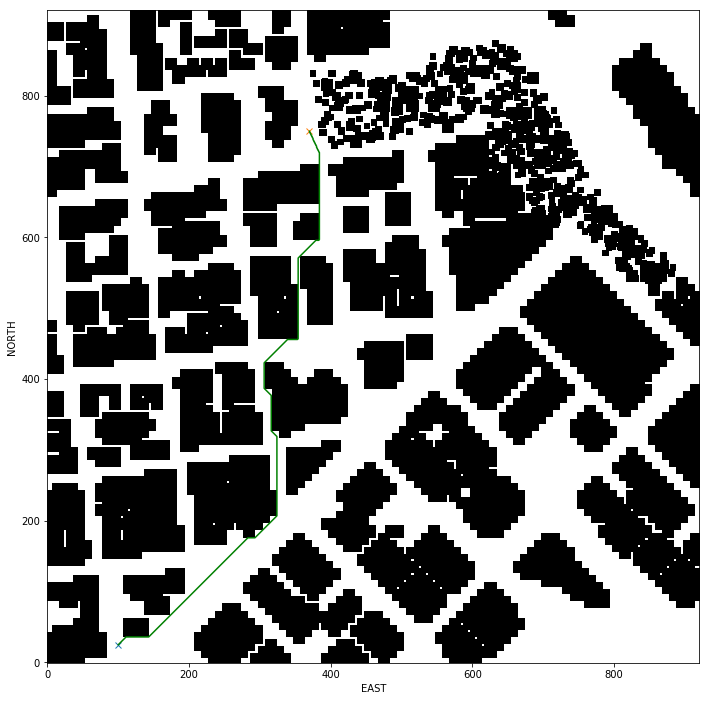

In [11]:
plt.imshow(grid, cmap='Greys', origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

if path is not None:
    pp = np.array(path)
    plt.plot(pp[:, 1], pp[:, 0], 'g')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Pretty neat! Unfortunately this path is impractical, the drone would be constantly stopping and going since each grid cell visited is synonymous with a waypoint. Ideally, we'd like to only consider a new waypoint when the drone's direction changes. Path pruning is one way to achieve this result.

### Path Pruning

In [12]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

Complete the `prune_path` function below. It should return a new path much shorter than the original.

In [17]:
def prune_path(path):
    if path is not None:
        pruned_path = [path[0]]
        # TODO: prune the path!
        if False:
            # This version uses collinearity:
            j = 2
            while j < len(path):
                pi = pruned_path[-1]
                redundant = collinearity_check(point(pi), point(path[j-1]), point(path[j]))
                if redundant:
                    j += 1
                else:
                    pruned_path.append(path[j-1])
                    j += 1
            pruned_path.append(path[-1])
        else:
            # This version uses ray tracing:
            j = 1
            while j < len(path):
                pi = pruned_path[-1]
                pe = path[j]
                ray = bresenham(pi[0], pi[1], int(pe[0]), int(pe[1]))
                redundant = (np.sum([grid[ri,rj] for ri, rj in ray]) == 0)
                if redundant:
                    j += 1
                else:
                    pruned_path.append(path[j-1])
            pruned_path.append(path[-1])

    else:
        pruned_path = path
        
    return pruned_path

Prune the path.

In [18]:
pruned_path = prune_path(path)
print(pruned_path)

[(25, 100), (36, 143), (183, 300), (207, 324), (320, 323), (327, 316), (390, 306), (423, 306), (457, 354), (573, 356), (597, 384), (720, 384), (750.0, 370.0)]


In [19]:
pruned_path

[(25, 100),
 (36, 143),
 (183, 300),
 (207, 324),
 (320, 323),
 (327, 316),
 (390, 306),
 (423, 306),
 (457, 354),
 (573, 356),
 (597, 384),
 (720, 384),
 (750.0, 370.0)]

Replot the path, it will be the same as before but the drone flight will be much smoother.

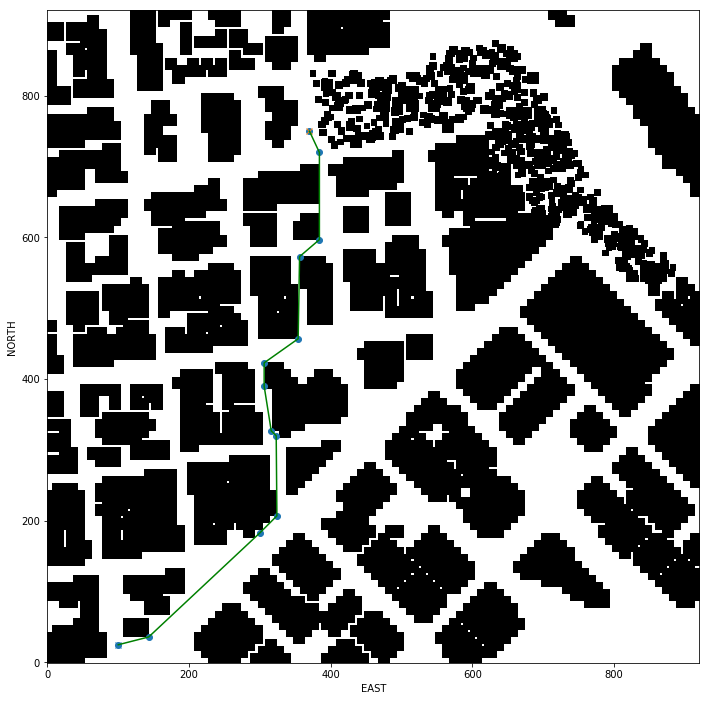

In [20]:
plt.imshow(grid, cmap='Greys', origin='lower')

plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

if pruned_path is not None:
    pp = np.array(pruned_path)
    plt.plot(pp[:, 1], pp[:, 0], 'g')
    plt.scatter(pp[:, 1], pp[:, 0])

plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()

Now the waypoints symbolize a change in direction, much better!

[solution](/notebooks/A-Star-City-Solution.ipynb)